*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 16: Modeling Sequential Data Using Recurrent Neural Networks (Part 1/2)

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow,tensorflow_datasets

Author: Sebastian Raschka & Vahid Mirjalili

Last updated: 2021-07-30

numpy              : 1.20.3
scipy              : 1.6.3
matplotlib         : 3.4.2
tensorflow         : 2.4.1
tensorflow_datasets: 4.4.0



In [2]:
from IPython.display import Image
%matplotlib inline

# Introducing sequential data

## Modeling sequential data⁠—order matters

## Representing sequences



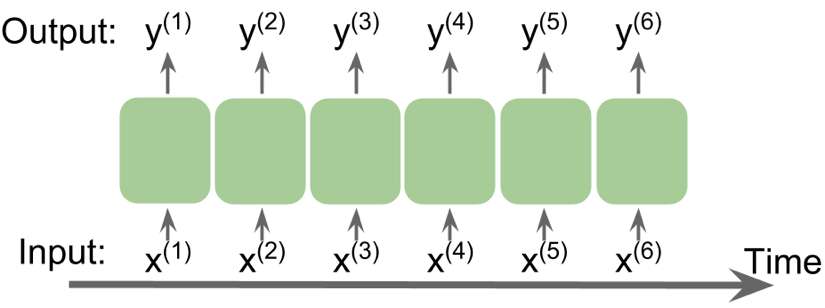

In [3]:
Image(filename='images/16_01.png', width=700)

## The different categories of sequence modeling

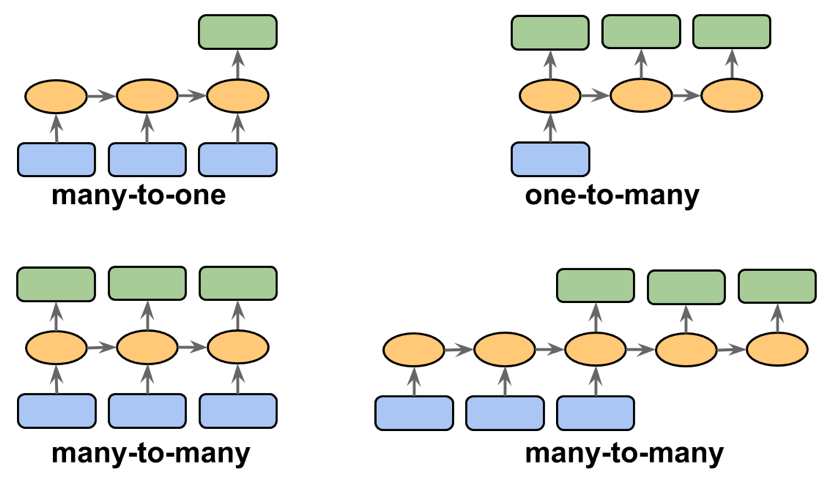

In [4]:
Image(filename='images/16_02.png', width=700)

# RNNs for modeling sequences

## Understanding the RNN looping mechanism


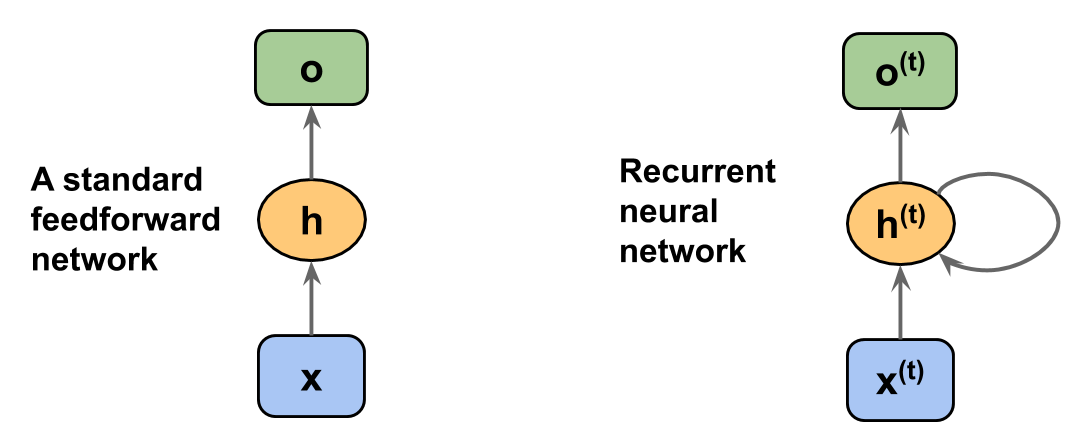

In [5]:
Image(filename='images/16_03.png', width=700)

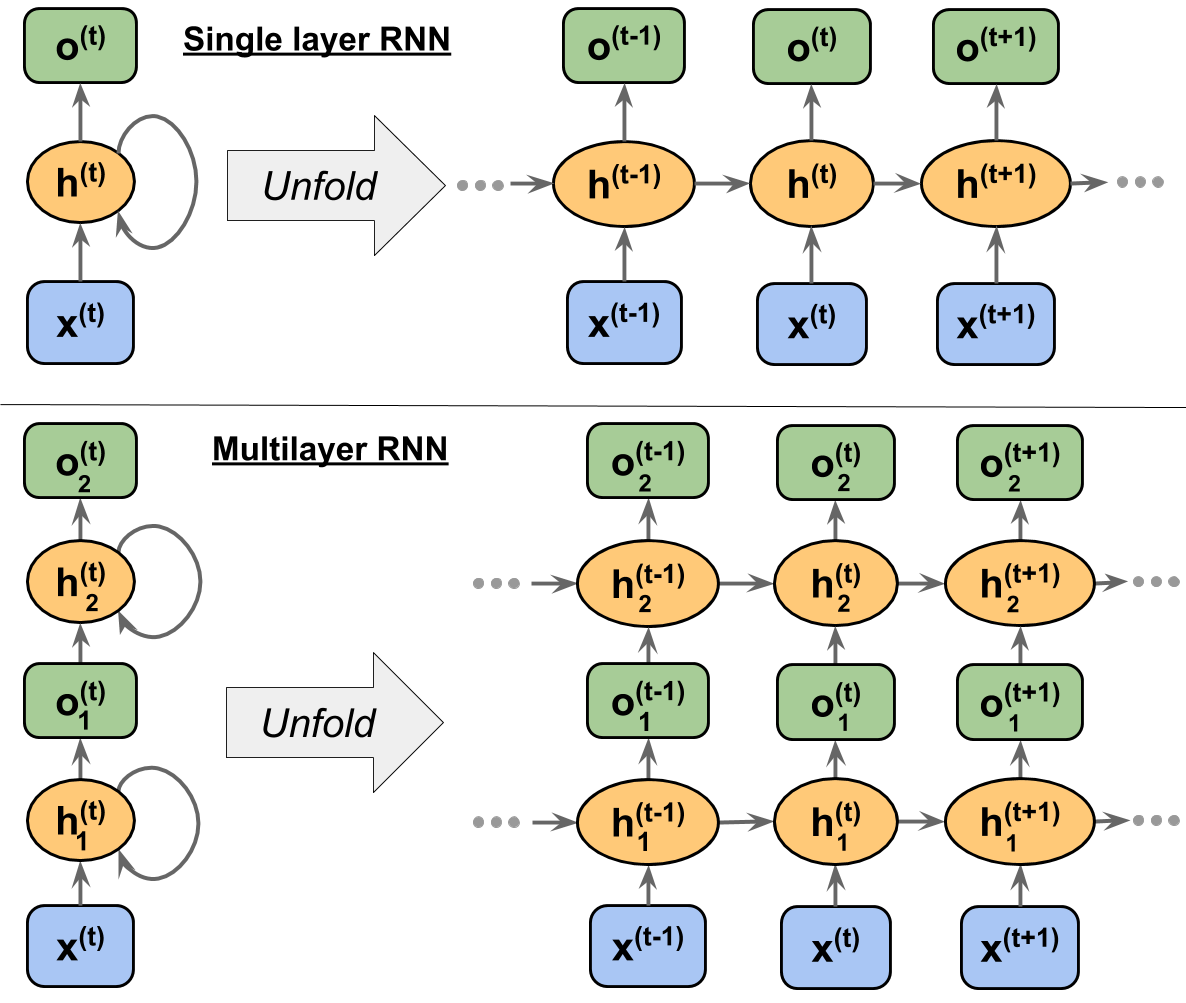

In [6]:
Image(filename='images/16_04.png', width=700)

## Computing activations in an RNN


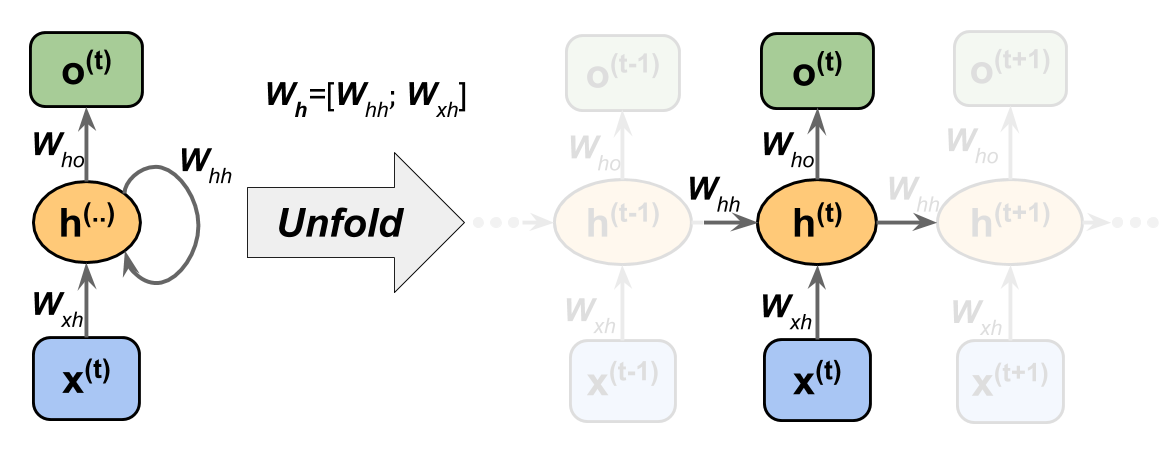

In [7]:
Image(filename='images/16_05.png', width=700)

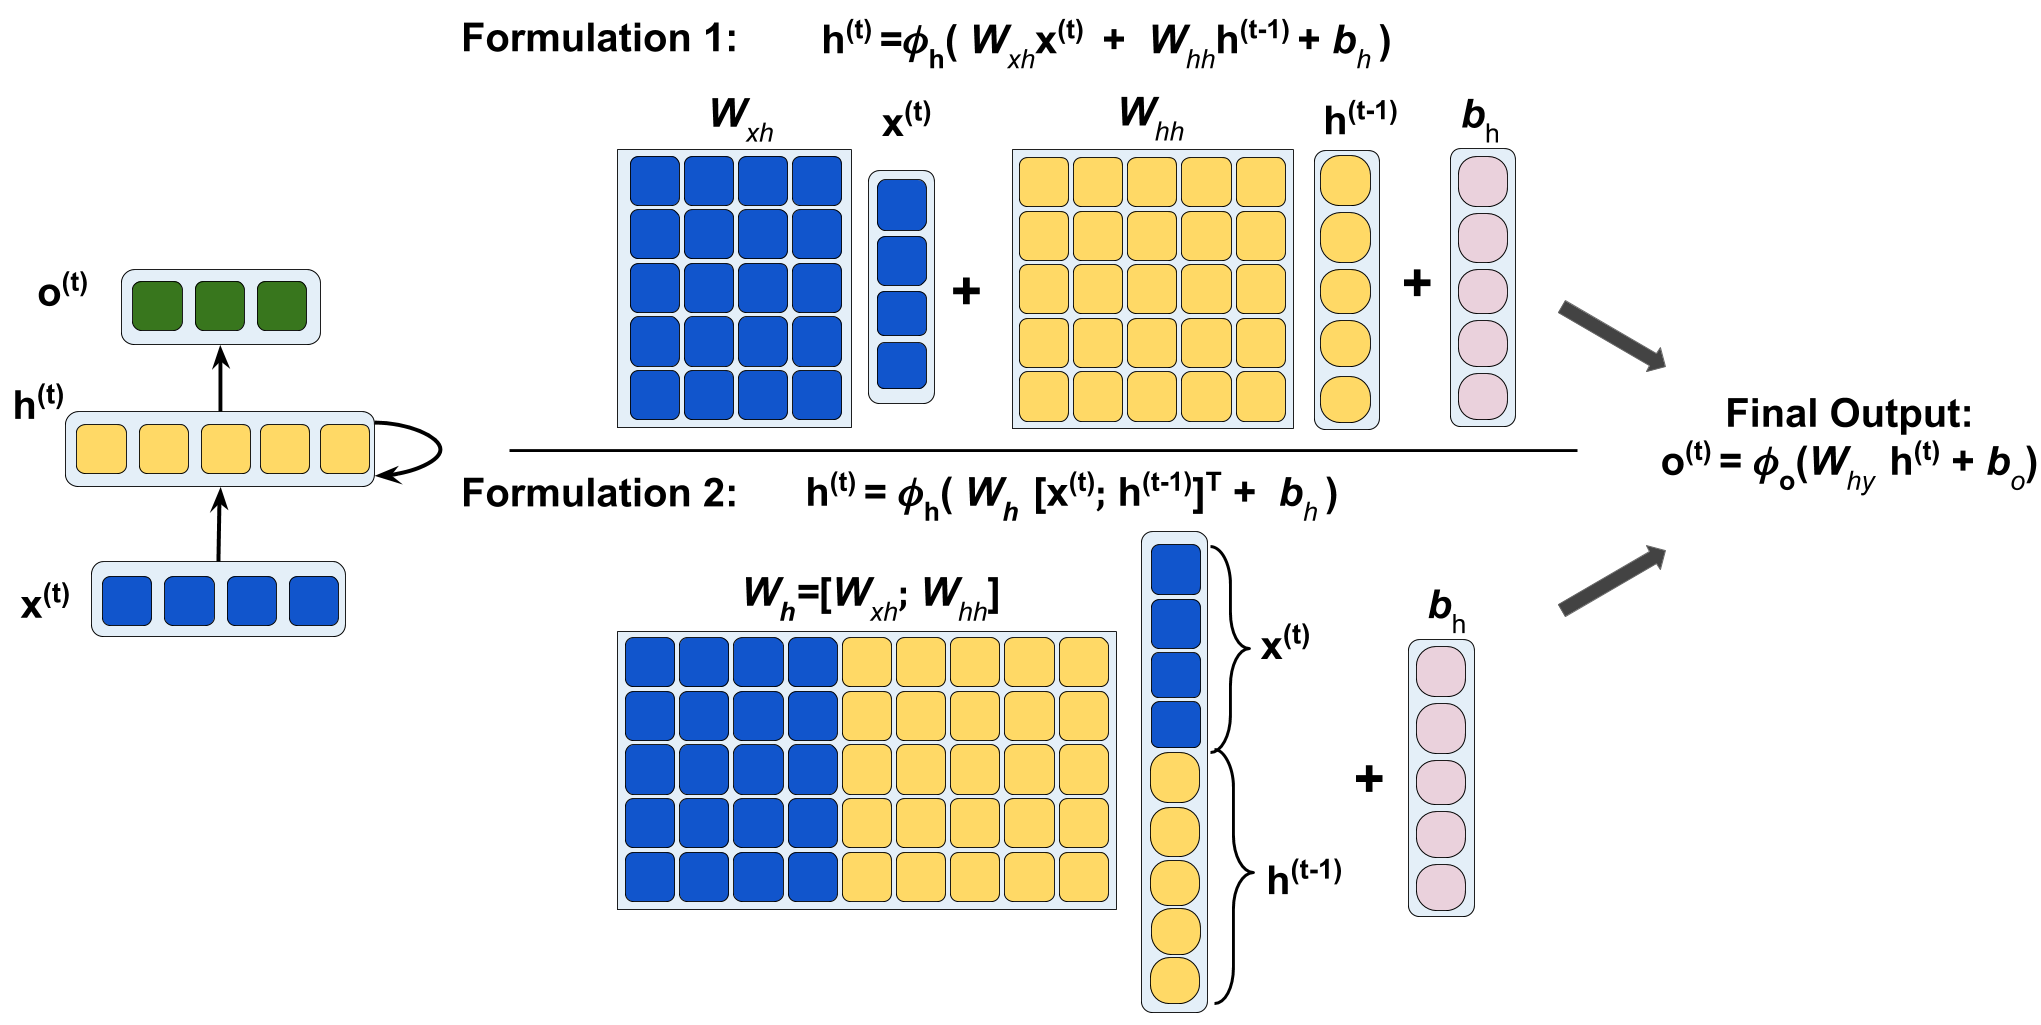

In [8]:
Image(filename='images/16_06.png', width=700)

## Hidden-recurrence vs. output-recurrence

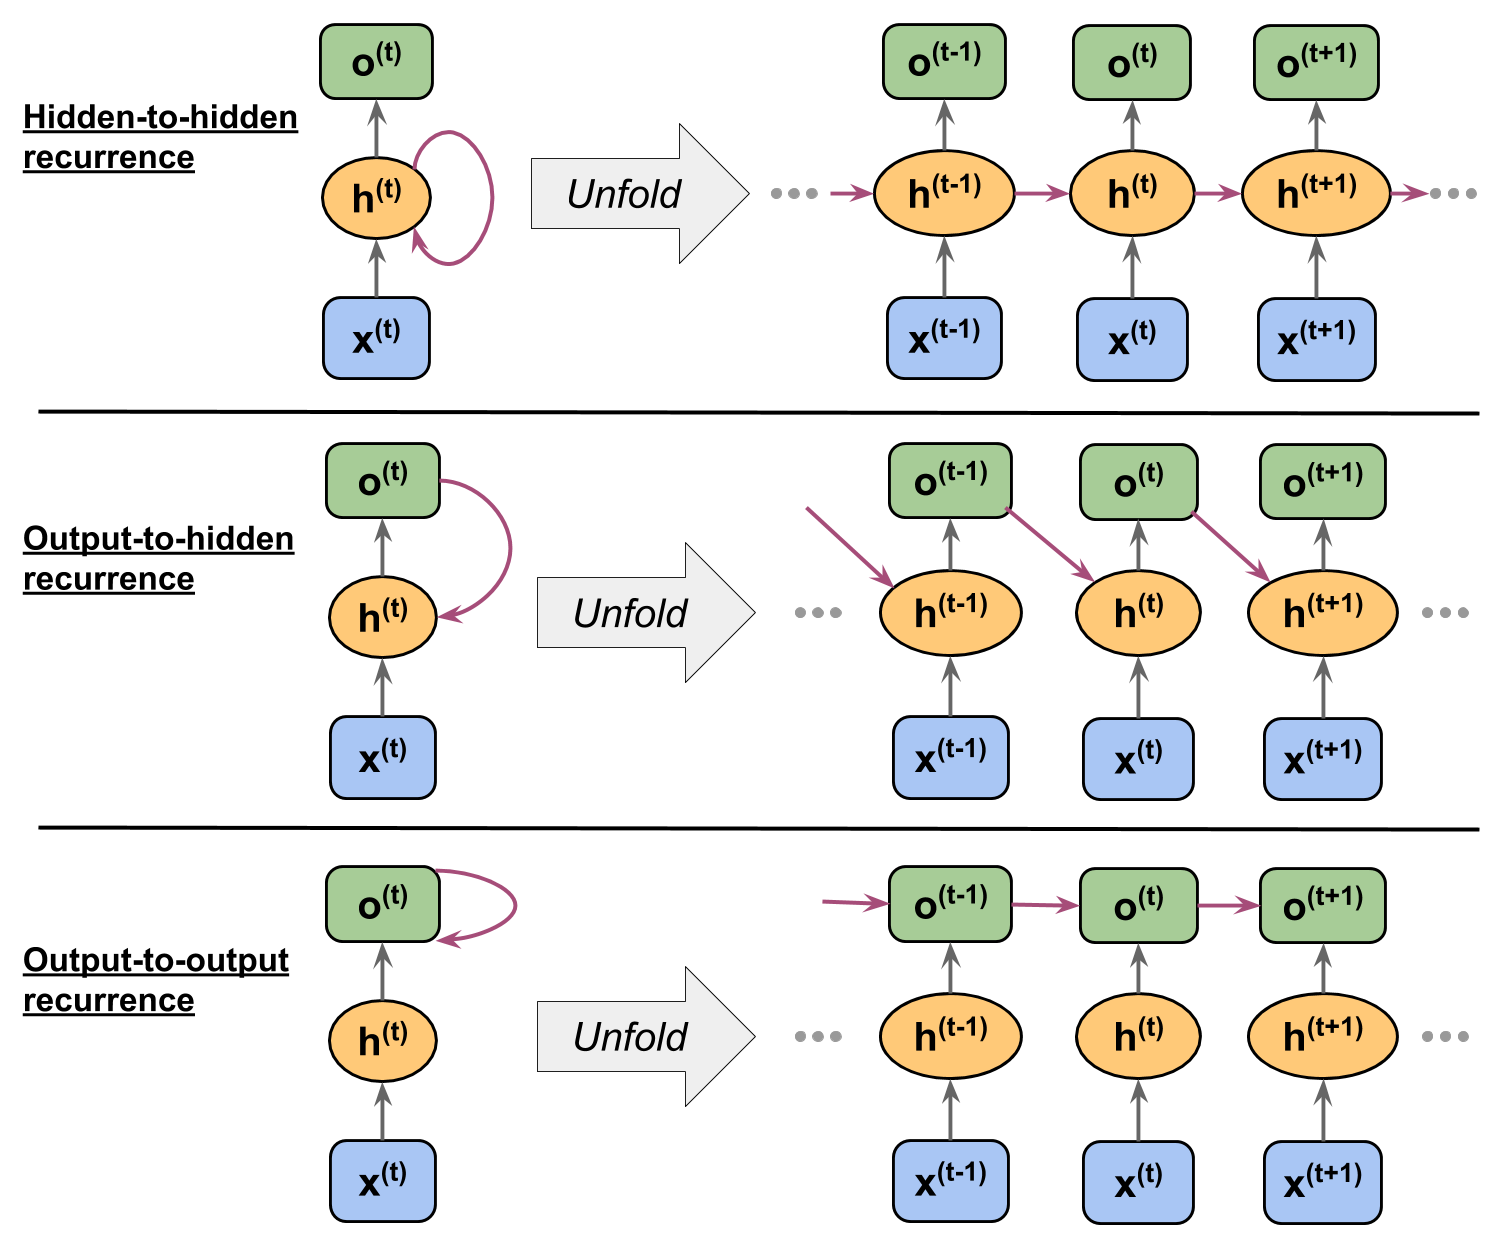

In [9]:
Image(filename='images/16_07.png', width=700)

In [10]:
import tensorflow as tf
tf.random.set_seed(1)

rnn_layer = tf.keras.layers.SimpleRNN(
    units=2, use_bias=True, 
    return_sequences=True)
rnn_layer.build(input_shape=(None, None, 5))

w_xh, w_oo, b_h = rnn_layer.weights

print('W_xh shape:', w_xh.shape)
print('W_oo shape:', w_oo.shape)
print('b_h shape:', b_h.shape)

W_xh shape: (5, 2)
W_oo shape: (2, 2)
b_h shape: (2,)


In [11]:
x_seq = tf.convert_to_tensor(
    [[1.0]*5, [2.0]*5, [3.0]*5],
    dtype=tf.float32)


## output of SimepleRNN:
output = rnn_layer(tf.reshape(x_seq, shape=(1, 3, 5)))

## manually computing the output:
out_man = []
for t in range(len(x_seq)):
    xt = tf.reshape(x_seq[t], (1, 5))
    print('Time step {} =>'.format(t))
    print('   Input           :', xt.numpy())
    
    ht = tf.matmul(xt, w_xh) + b_h    
    print('   Hidden          :', ht.numpy())
    
    if t>0:
        prev_o = out_man[t-1]
    else:
        prev_o = tf.zeros(shape=(ht.shape))
        
    ot = ht + tf.matmul(prev_o, w_oo)
    ot = tf.math.tanh(ot)
    out_man.append(ot)
    print('   Output (manual) :', ot.numpy())
    print('   SimpleRNN output:'.format(t), output[0][t].numpy())
    print()

Time step 0 =>
   Input           : [[1. 1. 1. 1. 1.]]
   Hidden          : [[0.41464037 0.96012145]]
   Output (manual) : [[0.39240566 0.74433106]]
   SimpleRNN output: [0.39240566 0.74433106]

Time step 1 =>
   Input           : [[2. 2. 2. 2. 2.]]
   Hidden          : [[0.82928073 1.9202429 ]]
   Output (manual) : [[0.80116504 0.9912947 ]]
   SimpleRNN output: [0.80116504 0.9912947 ]

Time step 2 =>
   Input           : [[3. 3. 3. 3. 3.]]
   Hidden          : [[1.243921  2.8803642]]
   Output (manual) : [[0.95468265 0.9993069 ]]
   SimpleRNN output: [0.95468265 0.9993069 ]



## The challenges of learning long-range interactions


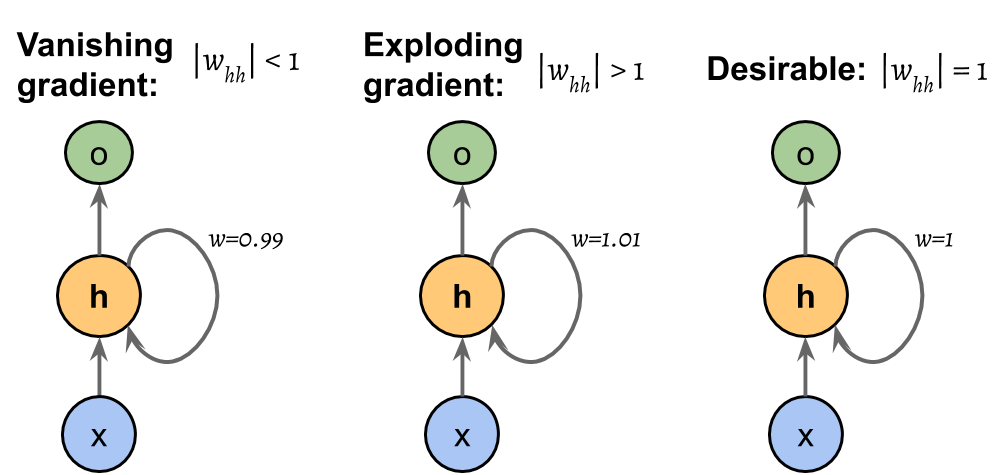

In [12]:
Image(filename='images/16_08.png', width=700)


## Long Short-Term Memory cells 

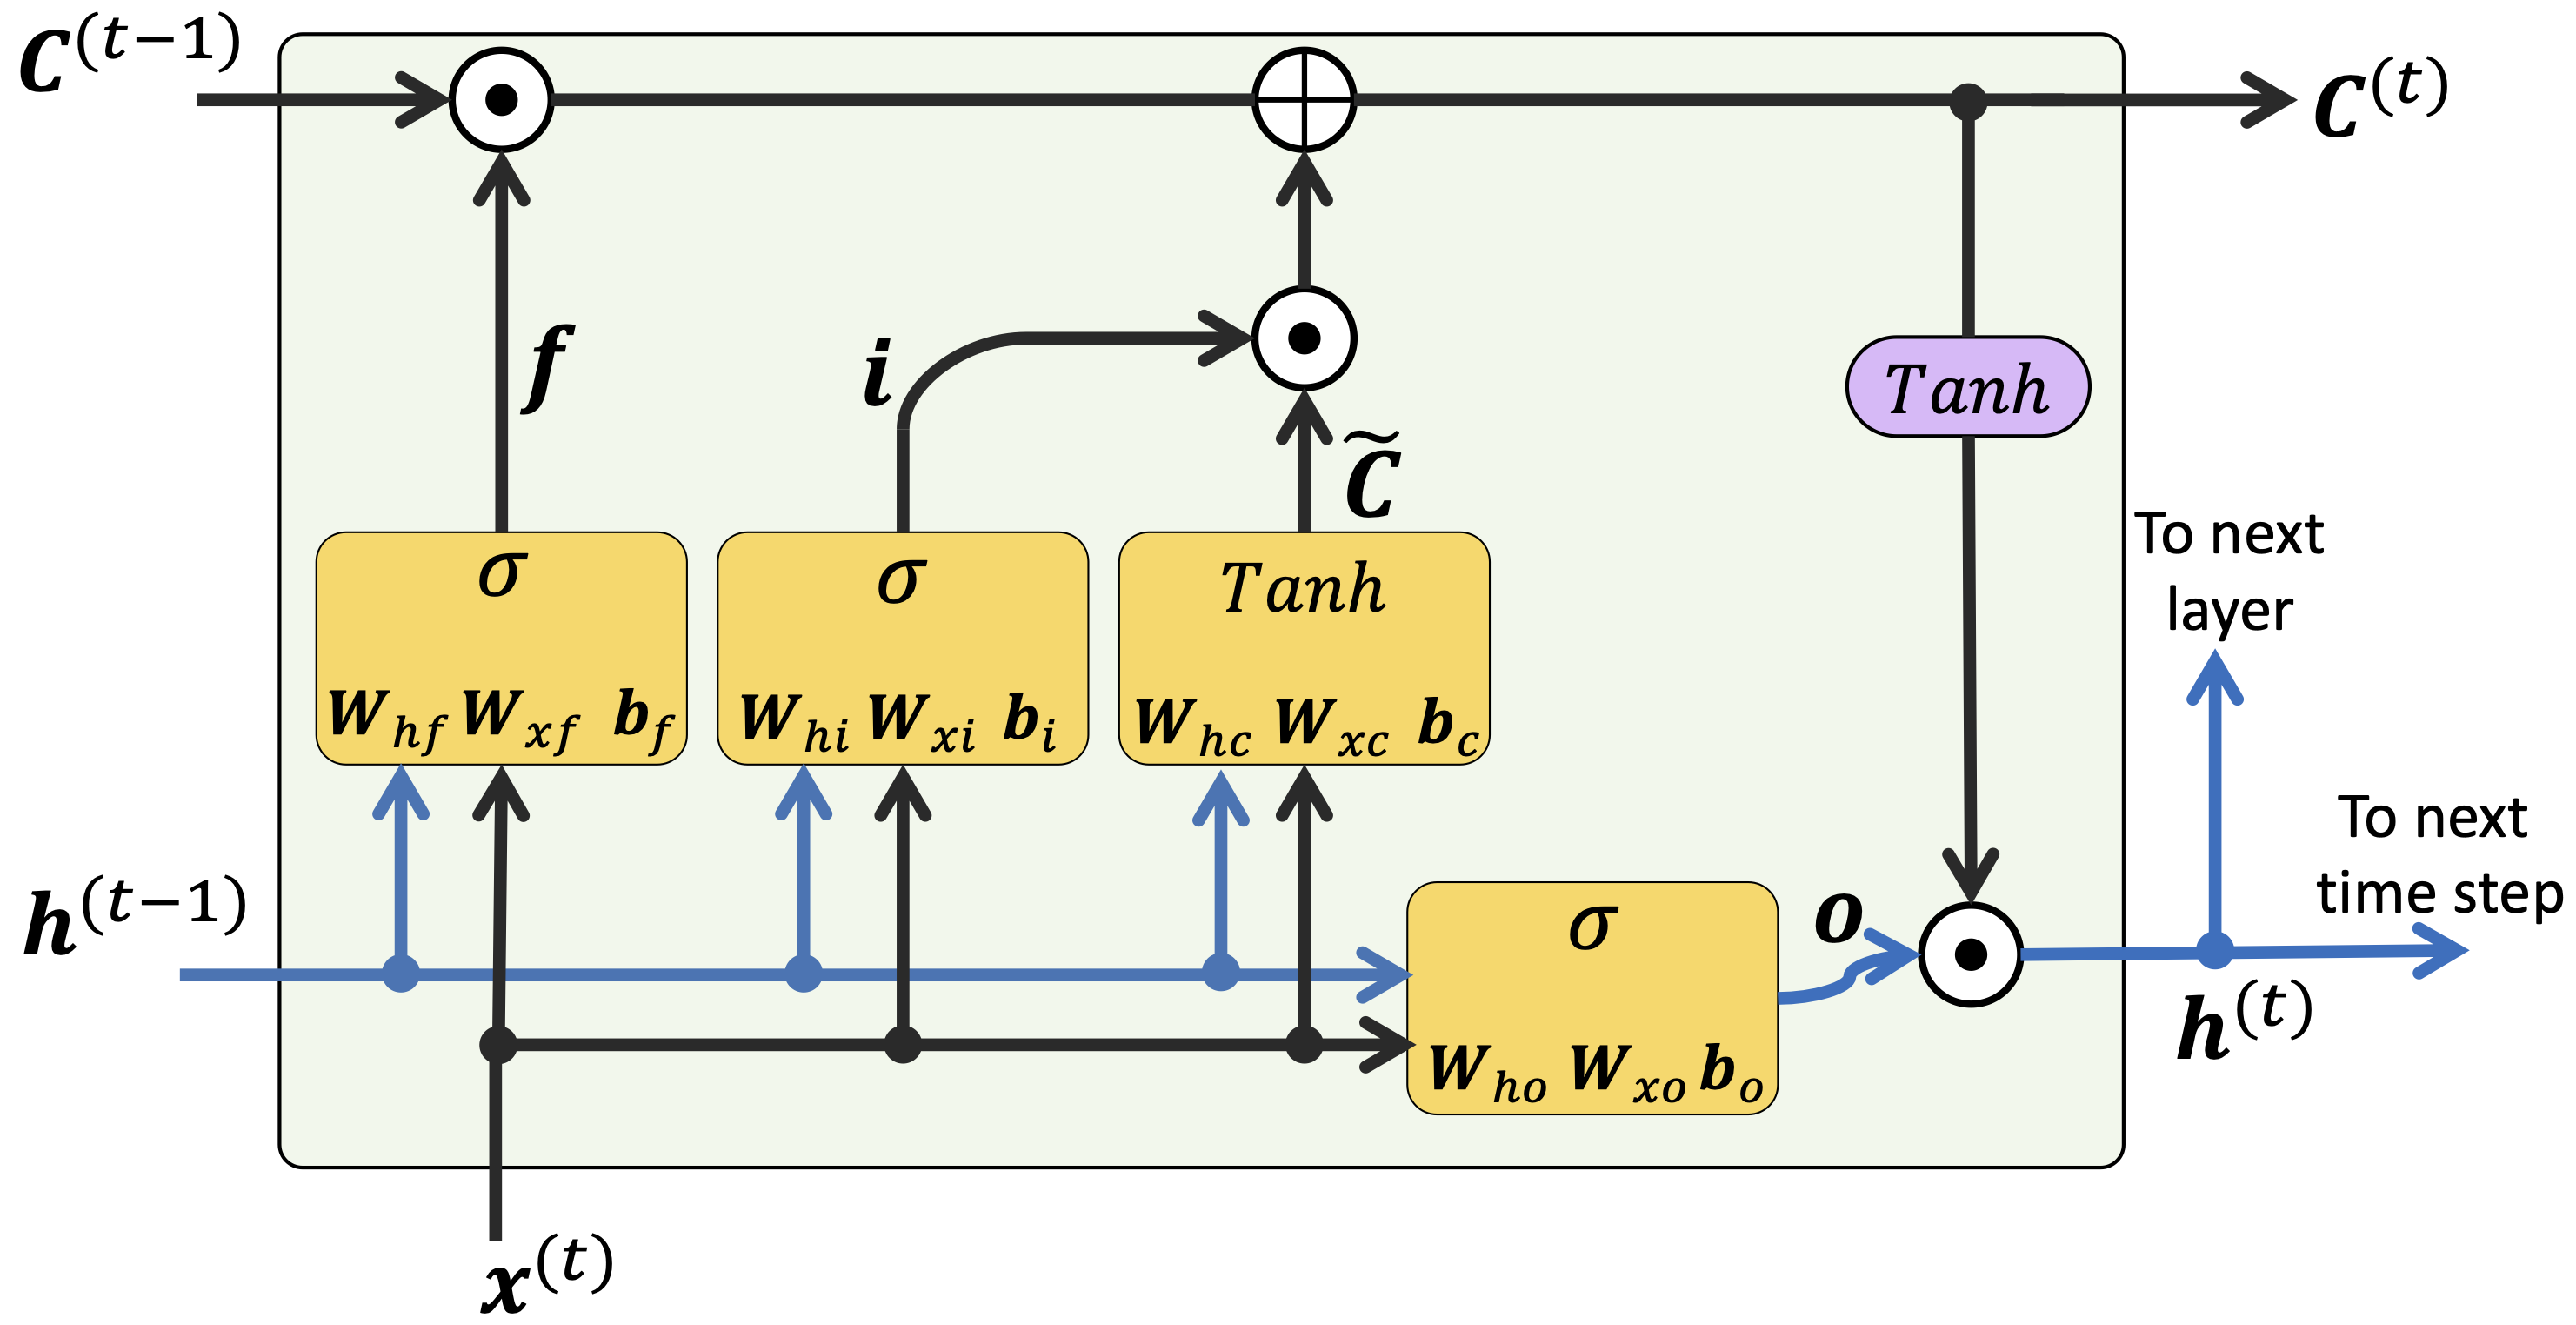

In [13]:
Image(filename='images/16_09.png', width=700)

# Implementing RNNs for sequence modeling in TensorFlow

## Project one: predicting the sentiment of IMDb movie reviews

### Preparing the movie review data



In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd

In [15]:
import os
import gzip
import shutil


with gzip.open('../ch08/movie_data.csv.gz', 'rb') as f_in, open('movie_data.csv', 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

In [16]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')

df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


In [17]:
# Step 1: Create a dataset

target = df.pop('sentiment')

ds_raw = tf.data.Dataset.from_tensor_slices(
    (df.values, target.values))

## inspection:
for ex in ds_raw.take(3):
    tf.print(ex[0].numpy()[0][:50], ex[1])

b'In 1974, the teenager Martha Moxley (Maggie Grace)' 1
b'OK... so... I really like Kris Kristofferson and h' 0
b'***SPOILER*** Do not read this, if you think about' 0


 * **Train/validaiton/test splits**

In [18]:
tf.random.set_seed(1)

ds_raw = ds_raw.shuffle(
    50000, reshuffle_each_iteration=False)

ds_raw_test = ds_raw.take(25000)
ds_raw_train_valid = ds_raw.skip(25000)
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

 * **Tokenizer and Encoder**
   * `tfds.features.text.Tokenizer`: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/Tokenizer
   * `tfds.features.text.TokenTextEncoder`: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/TokenTextEncoder

 * **Encoding sequences: keeping the last 100 items in each sequence**

In [19]:
## Step 2: find unique tokens (words)

from collections import Counter

try:
    tokenizer = tfds.features.text.Tokenizer()
except AttributeError:
    tokenizer = tfds.deprecated.text.Tokenizer()
    
token_counts = Counter()

for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Vocab-size:', len(token_counts))

Vocab-size: 87007


In [20]:
## Step 3: encoding each unique token into integers

try:
    encoder = tfds.features.text.TokenTextEncoder(token_counts)
except AttributeError:
    encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

example_str = 'This is an example!'
encoder.encode(example_str)

[232, 9, 270, 1123]

In [21]:
## Step 3-A: define the function for transformation

def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

## Step 3-B: wrap the encode function to a TF Op.
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

In [22]:
ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
ds_test = ds_raw_test.map(encode_map_fn)

tf.random.set_seed(1)
for example in ds_train.shuffle(1000).take(5):
    print('Sequence length:', example[0].shape)
    
example

Sequence length: (24,)
Sequence length: (179,)
Sequence length: (262,)
Sequence length: (535,)
Sequence length: (130,)


(<tf.Tensor: id=43302, shape=(130,), dtype=int64, numpy=
 array([  579,  1296,    32,   425,    40,   763,  9267,    65,   280,
          308,     6,   481,   155,   473,     2,     3,   684,     9,
          781,   176,   959,   730,  3917,    67,  9905,    13,   277,
           24,    35,   371, 16368,     6,    14, 17231,    29,   187,
         1651,   489,   503,   480,   143,    32,   270,  5851,  2402,
           13,  3592,  3443,   425,  3313,   256,   257,  1577,   117,
            8,   698,   270,   564,    56,     8,    42,  7517,  2629,
          820,    25,    60,    79,   343,    32,   645,    14,   528,
          241,    32,  1980,     8,    56,     8,    42,  1364,   573,
         5183,    43,    12,  3870,    32,   312,   642,   251,  1401,
        17232,     8,   698,   257,   750,     2,     9,    76,   235,
            8,    42,   235,   840,   666,   258, 17233,   419,    32,
        17234,   585,   420,   840,    25,    40,    13,    14,   198,
          266,   623

 * **batch() vs. padded_batch()**

```python

# this will result in error


BATCH_SIZE = 32
train_data = all_encoded_data.batch(BATCH_SIZE)

next(iter(train_data))

# Running this will result in error
# We cannot apply .batch() to this dataset
```

In [23]:
## Take a small subset

ds_subset = ds_train.take(8)
for example in ds_subset:
    print('Individual size:', example[0].shape)

## batching the datasets
ds_batched = ds_subset.padded_batch(
    4, padded_shapes=([-1], []))

for batch in ds_batched:
    print('Batch dimension:', batch[0].shape)

Individual Shape: (119,)
Individual Shape: (688,)
Individual Shape: (308,)
Individual Shape: (204,)
Individual Shape: (326,)
Individual Shape: (240,)
Individual Shape: (127,)
Individual Shape: (453,)
Batch Shape: (4, 688)
Batch Shape: (4, 453)


In [24]:
## batching the datasets
train_data = ds_train.padded_batch(
    32, padded_shapes=([-1],[]))

valid_data = ds_valid.padded_batch(
    32, padded_shapes=([-1],[]))

test_data = ds_test.padded_batch(
    32, padded_shapes=([-1],[]))

### Embedding layers for sentence encoding


 * `input_dim`: number of words, i.e. maximum integer index + 1.
 * `output_dim`: 
 * `input_length`: the length of (padded) sequence
    * for example, `'This is an example' -> [0, 0, 0, 0, 0, 0, 3, 1, 8, 9]`   
    => input_lenght is 10
 
 

 * When calling the layer, takes integr values as input,   
 the embedding layer convert each interger into float vector of size `[output_dim]`
   * If input shape is `[BATCH_SIZE]`, output shape will be `[BATCH_SIZE, output_dim]`
   * If input shape is `[BATCH_SIZE, 10]`, output shape will be `[BATCH_SIZE, 10, output_dim]`

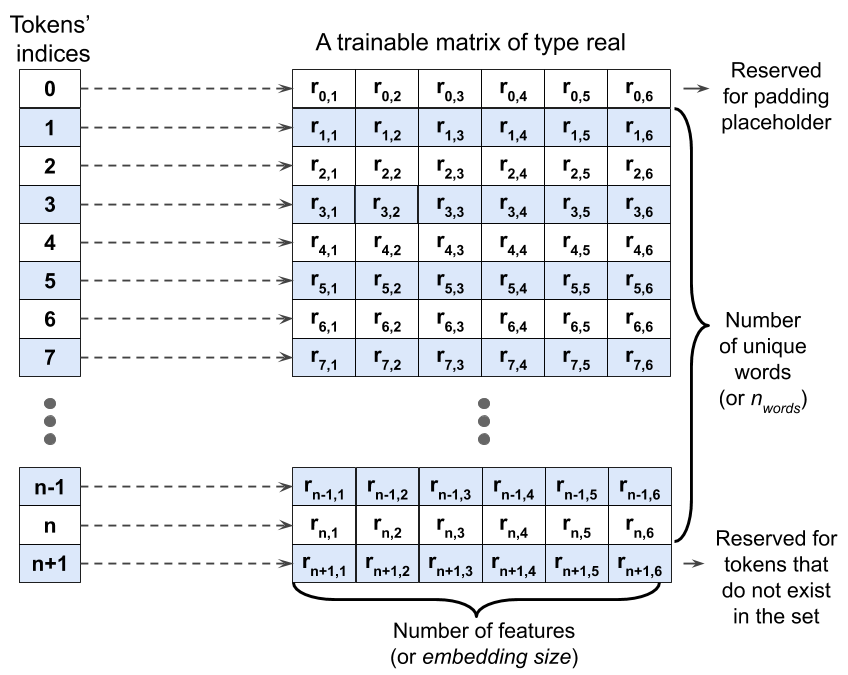

In [25]:
Image(filename='images/16_10.png', width=700)

In [26]:
from tensorflow.keras.layers import Embedding


model = tf.keras.Sequential()

model.add(Embedding(input_dim=100,
                    output_dim=6,
                    input_length=20,
                    name='embed-layer'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, 20, 6)             600       
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


### Building an RNN model

* **Keras RNN layers:**
  * `tf.keras.layers.SimpleRNN(units, return_sequences=False)`
  * `tf.keras.layers.LSTM(..)`
  * `tf.keras.layers.GRU(..)`
  * `tf.keras.layers.Bidirectional()`
 
* **Determine `return_sequenes=?`**
  * In a multi-layer RNN, all RNN layers except the last one should have `return_sequenes=True`
  * For the last RNN layer, decide based on the type of problem: 
     * many-to-many: -> `return_sequences=True`
     * many-to-one : -> `return_sequenes=False`
     * ..
    

In [27]:
## An example of building a RNN model
## with SimpleRNN layer

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Embedding(1000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 36,193
Trainable params: 36,193
Non-trainable params: 0
_________________________________________________________________


In [28]:
## An example of building a RNN model
## with LSTM layer


from tensorflow.keras.layers import LSTM


model = Sequential()
model.add(Embedding(10000, 32))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 336,673
Trainable params: 336,673
Non-trainable params: 0
_________________________________________________________________


In [29]:
## An example of building a RNN model
## with GRU layer
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(Embedding(10000, 32))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
gru (GRU)                    (None, None, 32)          6336      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 332,705
Trainable params: 332,705
Non-trainable params: 0
_________________________________________________________________


### Building an RNN model for the sentiment analysis task

In [30]:
embedding_dim = 20
vocab_size = len(token_counts) + 2

tf.random.set_seed(1)

## build the model
bi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        name='embed-layer'),
    
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, name='lstm-layer'),
        name='bidir-lstm'), 

    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

bi_lstm_model.summary()

## compile and train:
bi_lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy'])

history = bi_lstm_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

## evaluate on the test data
test_results= bi_lstm_model.evaluate(test_data)
print('Test Acc.: {:.2f}%'.format(test_results[1]*100))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1740180   
_________________________________________________________________
bidir-lstm (Bidirectional)   (None, 128)               43520     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,792,021
Trainable params: 1,792,021
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 383s 613ms/step - loss: 0.5173 - accuracy: 0.7376 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
625/625 [==============================] - 369s 590ms/step - loss: 0.2747 - a

In [31]:
if not os.path.exists('models'):
    os.mkdir('models')


bi_lstm_model.save('models/Bidir-LSTM-full-length-seq.h5')

 * **Trying SimpleRNN with short sequences**

In [32]:
def preprocess_datasets(
    ds_raw_train, 
    ds_raw_valid, 
    ds_raw_test,
    max_seq_length=None,
    batch_size=32):
    
    ## Step 1: (already done => creating a dataset)
    ## Step 2: find unique tokens
    tokenizer = tfds.features.text.Tokenizer()
    token_counts = Counter()

    for example in ds_raw_train:
        tokens = tokenizer.tokenize(example[0].numpy()[0])
        if max_seq_length is not None:
            tokens = tokens[-max_seq_length:]
        token_counts.update(tokens)

    print('Vocab-size:', len(token_counts))


    ## Step 3: encoding the texts
    encoder = tfds.features.text.TokenTextEncoder(token_counts)
    def encode(text_tensor, label):
        text = text_tensor.numpy()[0]
        encoded_text = encoder.encode(text)
        if max_seq_length is not None:
            encoded_text = encoded_text[-max_seq_length:]
        return encoded_text, label

    def encode_map_fn(text, label):
        return tf.py_function(encode, inp=[text, label], 
                              Tout=(tf.int64, tf.int64))

    ds_train = ds_raw_train.map(encode_map_fn)
    ds_valid = ds_raw_valid.map(encode_map_fn)
    ds_test = ds_raw_test.map(encode_map_fn)

    ## Step 4: batching the datasets
    train_data = ds_train.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    valid_data = ds_valid.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    test_data = ds_test.padded_batch(
        batch_size, padded_shapes=([-1],[]))

    return (train_data, valid_data, 
            test_data, len(token_counts))

In [33]:
def build_rnn_model(embedding_dim, vocab_size,
                    recurrent_type='SimpleRNN',
                    n_recurrent_units=64,
                    n_recurrent_layers=1,
                    bidirectional=True):

    tf.random.set_seed(1)

    # build the model
    model = tf.keras.Sequential()
    
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            name='embed-layer')
    )
    
    for i in range(n_recurrent_layers):
        return_sequences = (i < n_recurrent_layers-1)
            
        if recurrent_type == 'SimpleRNN':
            recurrent_layer = SimpleRNN(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='simprnn-layer-{}'.format(i))
        elif recurrent_type == 'LSTM':
            recurrent_layer = LSTM(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='lstm-layer-{}'.format(i))
        elif recurrent_type == 'GRU':
            recurrent_layer = GRU(
                units=n_recurrent_units, 
                return_sequences=return_sequences,
                name='gru-layer-{}'.format(i))
        
        if bidirectional:
            recurrent_layer = Bidirectional(
                recurrent_layer, name='bidir-'+recurrent_layer.name)
            
        model.add(recurrent_layer)

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model


In [34]:
from tensorflow.keras.layers import Bidirectional


batch_size = 32
embedding_dim = 20
max_seq_length = 100

train_data, valid_data, test_data, n = preprocess_datasets(
    ds_raw_train, ds_raw_valid, ds_raw_test, 
    max_seq_length=max_seq_length, 
    batch_size=batch_size
)


vocab_size = n + 2

rnn_model = build_rnn_model(
    embedding_dim, vocab_size,
    recurrent_type='SimpleRNN', 
    n_recurrent_units=64,
    n_recurrent_layers=1,
    bidirectional=True)

rnn_model.summary()

Vocab-size: 58063
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1161300   
_________________________________________________________________
bidir-simprnn-layer-0 (Bidir (None, 128)               10880     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,180,501
Trainable params: 1,180,501
Non-trainable params: 0
_________________________________________________________________


In [35]:
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])


history = rnn_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

Epoch 1/10
625/625 [==============================] - 68s 109ms/step - loss: 0.7055 - accuracy: 0.5026 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
625/625 [==============================] - 66s 106ms/step - loss: 0.7037 - accuracy: 0.5113 - val_loss: 0.6953 - val_accuracy: 0.5072
Epoch 3/10
625/625 [==============================] - 66s 106ms/step - loss: 0.6954 - accuracy: 0.5213 - val_loss: 0.6884 - val_accuracy: 0.5452
Epoch 4/10
625/625 [==============================] - 67s 106ms/step - loss: 0.6317 - accuracy: 0.6259 - val_loss: 0.6152 - val_accuracy: 0.6522
Epoch 5/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4913 - accuracy: 0.7629 - val_loss: 0.7798 - val_accuracy: 0.6278
Epoch 6/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4252 - accuracy: 0.8094 - val_loss: 0.6105 - val_accuracy: 0.7432
Epoch 7/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4100 - accuracy: 0.8122 - val_loss: 0.6718 

In [36]:
results = rnn_model.evaluate(test_data)

782/782 [==============================] - 39s 50ms/step - loss: 0.7098 - accuracy: 0.7478


In [37]:
print('Test Acc.: {:.2f}%'.format(results[1]*100))

Test Acc.: 74.78%


## Optional exercise: 

### Uni-directional SimpleRNN with full-length sequences

In [38]:
batch_size = 32
embedding_dim = 20
max_seq_length = None

train_data, valid_data, test_data, n = preprocess_datasets(
    ds_raw_train, ds_raw_valid, ds_raw_test, 
    max_seq_length=max_seq_length, 
    batch_size=batch_size
)


vocab_size = n + 2

rnn_model = build_rnn_model(
    embedding_dim, vocab_size,
    recurrent_type='SimpleRNN', 
    n_recurrent_units=64,
    n_recurrent_layers=1,
    bidirectional=False)

rnn_model.summary()

Vocab-size: 87007
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed-layer (Embedding)      (None, None, 20)          1740180   
_________________________________________________________________
simprnn-layer-0 (SimpleRNN)  (None, 64)                5440      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 1,749,845
Trainable params: 1,749,845
Non-trainable params: 0
_________________________________________________________________


In [39]:
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

history = rnn_model.fit(
    train_data, 
    validation_data=valid_data, 
    epochs=10)

Epoch 1/10
625/625 [==============================] - 225s 361ms/step - loss: 0.6993 - accuracy: 0.5034 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
625/625 [==============================] - 225s 361ms/step - loss: 0.6993 - accuracy: 0.5006 - val_loss: 0.6998 - val_accuracy: 0.5010
Epoch 3/10
625/625 [==============================] - 226s 361ms/step - loss: 0.6968 - accuracy: 0.5034 - val_loss: 0.6960 - val_accuracy: 0.5004
Epoch 4/10
625/625 [==============================] - 225s 360ms/step - loss: 0.6958 - accuracy: 0.5038 - val_loss: 0.6953 - val_accuracy: 0.5002
Epoch 5/10
625/625 [==============================] - 226s 361ms/step - loss: 0.6952 - accuracy: 0.5045 - val_loss: 0.6947 - val_accuracy: 0.4952
Epoch 6/10
625/625 [==============================] - 226s 361ms/step - loss: 0.6945 - accuracy: 0.5080 - val_loss: 0.6945 - val_accuracy: 0.4956
Epoch 7/10
625/625 [==============================] - 225s 360ms/step - loss: 0.6940 - accuracy: 0.5109 - val_loss: 

# Appendix


### A -- An alternative way to get the dataset: using tensorflow_datasets

In [40]:
imdb_bldr = tfds.builder('imdb_reviews')
print(imdb_bldr.info)

imdb_bldr.download_and_prepare()

datasets = imdb_bldr.as_dataset(shuffle_files=False)

datasets.keys()


tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.1.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    urls=['http://ai.stanford.edu/~amaas/data/sentiment/'],
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word V

dict_keys(['test', 'train', 'unsupervised'])

In [41]:
imdb_train = datasets['train']
imdb_train = datasets['test']

### B -- Tokenizer and Encoder

 * `tfds.features.text.Tokenizer`: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/Tokenizer
 * `tfds.features.text.TokenTextEncoder`: https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/TokenTextEncoder



In [42]:
vocab_set = {'a', 'b', 'c', 'd'}
encoder = tfds.features.text.TokenTextEncoder(vocab_set)
print(encoder)

print(encoder.encode(b'a b c d, , : .'))

print(encoder.encode(b'a b c d e f g h i z'))

<TokenTextEncoder vocab_size=6>
[2, 1, 4, 3]
[2, 1, 4, 3, 5, 5, 5, 5, 5, 5]


### C -- Text Pre-processing with Keras 

In [43]:
TOP_K = 200
MAX_LEN = 10

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=TOP_K)

tokenizer.fit_on_texts(['this is an example', 'je suis en forme '])
sequences = tokenizer.texts_to_sequences(['this is an example', 'je suis en forme '])
print(sequences)

tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_LEN)

[[1, 2, 3, 4], [5, 6, 7, 8]]


array([[0, 0, 0, 0, 0, 0, 1, 2, 3, 4],
       [0, 0, 0, 0, 0, 0, 5, 6, 7, 8]], dtype=int32)

In [44]:
TOP_K = 20000
MAX_LEN = 500

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=TOP_K)

tokenizer.fit_on_texts(
    [example['text'].numpy().decode('utf-8') 
     for example in imdb_train])

x_train = tokenizer.texts_to_sequences(
    [example['text'].numpy().decode('utf-8')
     for example in imdb_train])

print(len(x_train))


x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
    x_train, maxlen=MAX_LEN)

print(x_train_padded.shape)

25000
(25000, 500)


### D -- Embedding



In [45]:
from tensorflow.keras.layers import Embedding


tf.random.set_seed(1)
embed = Embedding(input_dim=100, output_dim=4)

inp_arr = np.array([1, 98, 5, 6, 67, 45])
tf.print(embed(inp_arr))
tf.print(embed(inp_arr).shape)

tf.print(embed(np.array([1])))

[[-0.0208060984 0.0142502077 0.0475785471 -0.00649005175]
 [-0.00420691818 -0.0375086069 -0.00477621704 0.00311584398]
 [0.028728161 -0.0440448038 -0.0428906195 -0.019158531]
 [-0.0248817336 0.0408470519 -0.00285203382 -0.0257614851]
 [0.0443614833 0.00331580639 0.043055404 -0.011118304]
 [-0.0281324144 0.00720113516 0.0192188732 -0.0186921246]]
TensorShape([6, 4])
[[-0.0208060984 0.0142502077 0.0475785471 -0.00649005175]]


<br>
<br>

---



Readers may ignore the next cell.


In [46]:
! python ../.convert_notebook_to_script.py --input ch16_part1.ipynb --output ch16_part1.py

[NbConvertApp] Converting notebook ch16_part1.ipynb to script
[NbConvertApp] Writing 17277 bytes to ch16_part1.py
